<a href="https://colab.research.google.com/github/godinezseba/Tarea-2-RedesNeuronales/blob/master/notebooks/Parte%202/pruebas/Tarea_2_Parte_2_con_attri2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2 - Parte 2

In [ ]:
%pip install scanf==1.5.2
%pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 440kB 2.8MB/s 
     |████████████████████████████████| 235kB 12.6MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
import networkx as nx
import stellargraph as sg

import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification
from stellargraph import StellarGraph

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten, Input, Embedding, Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import os.path
from scanf import scanf

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!git clone https://github.com/godinezseba/Tarea-2-RedesNeuronales

Cloning into 'Tarea-2-RedesNeuronales'...
remote: Enumerating objects: 2152, done.
remote: Counting objects: 100% (2152/2152), done.
remote: Compressing objects: 100% (2152/2152), done.
remote: Total 35840 (delta 1), reused 2148 (delta 0), pack-reused 33688
Receiving objects: 100% (35840/35840), 797.68 MiB | 33.14 MiB/s, done.
Resolving deltas: 100% (325/325), done.
Checking out files: 100% (36724/36724), done.


## Pre-procesamiento de Grafo:
Dado que no encontramos la libreria utilizada para cargar los grafos lo hacemos a mano aprovechando la libreria `StellarGraph`. En primer lugar se carga el archivo ``train.labels.csv`, con el se identifican los archivos que tenemos que leer.



In [ ]:
labels = pd.read_csv('./Tarea-2-RedesNeuronales/datasets/Parte 2/train_labels.csv' )
# labels = labels.loc[0:100]
labels.head()

,label,id
0,non-rumor,692735698349199360
1,unverified,525008463819464704
2,false,505611045897924608
3,non-rumor,693466724822323200
4,true,510922415468449792


En esta sección se lee cada uno de los archivos y se genera un solo grafo, este grafo no contendra el nodo `ROOT` porque afecta en el recorrido de `RandomWalk`, el cual es implementado más adelante:

In [ ]:
def createGraph(DIR, fileGraph, labels):
  if(not os.path.exists(fileGraph)): # para ejecutar existiendo el archivo basta con quital el 'not'
    format = "['%s', '%s', '%f']->['%s', '%s', '%f']"
    # edges
    source = list()
    target = list()
    # nodes
    index = list()
    time = list()

    bigGraph = nx.Graph()

    list_len_edges = list()

    for file in labels:
      fileName = f'{DIR}/{file}.txt'
      count_edges = 0
      with open(fileName, 'r') as f:
        for line in f:
          parentId, parentTweet, parentTime, childId, childTweet, childTime = scanf(format, line.strip())
          if(parentId != 'ROOT'):
            # add edge to the big Graph
            bigGraph.add_edge(parentTweet, childTweet)
            count_edges += 1
            bigGraph.add_node(parentTweet, time=[parentTime])
            bigGraph.add_node(childTweet, time=[childTime])
      list_len_edges.append(count_edges)

    nx.write_gpickle(bigGraph, fileGraph)
  else:
    list_len_edges = list()
    bigGraph = nx.read_gpickle(fileGraph)
  return bigGraph, list_len_edges

In [ ]:
DIR = './Tarea-2-RedesNeuronales/datasets/Parte 2/train'
fileGraph = './drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/graph.gpicke'

# add new graph
bigGraph, list_len_edges = createGraph(DIR, fileGraph, labels['id'])
print(nx.info(bigGraph))
graph = sg.StellarGraph.from_networkx(bigGraph, node_features="time")
print(graph.info())

Name: 
Type: Graph
Number of nodes: 67723
Number of edges: 71020
Average degree:   2.0974
StellarGraph: Undirected multigraph
 Nodes: 67723, Edges: 71020

 Node types:
  default: [67723]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [71020]
        Weights: all 1 (default)
        Features: none


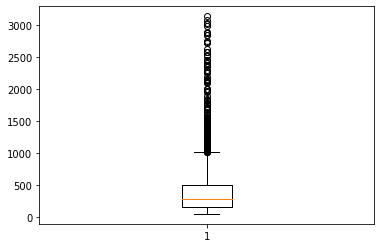

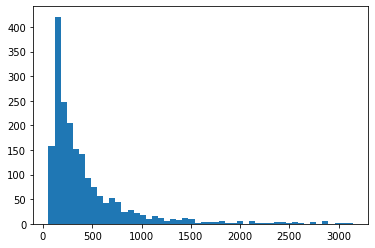

Minimo de replicaciones para un tweet: 55
Maximo de replicaciones para un tweet: 3144
Media de replicaciones para un tweet: 281.0
Promedio de replicaciones para un tweet: 433.09241952232605


In [ ]:
# no ejecutar
plt.boxplot(list_len_edges)
plt.show()
plt.hist(list_len_edges, 50)
plt.show()
print(f'Minimo de replicaciones para un tweet: {np.min(list_len_edges)}')
print(f'Maximo de replicaciones para un tweet: {np.max(list_len_edges)}')
print(f'Media de replicaciones para un tweet: {np.median(list_len_edges)}')
print(f'Promedio de replicaciones para un tweet: {np.mean(list_len_edges)}')

In [ ]:
# plt.figure(figsize=(20,10))
# nx.draw(bigGraph)
# plt.savefig(f'./drive/My Drive/Colab Notebooks/Tarea 2 - Kaggle/graph_representation.jpg')

![](https://raw.githubusercontent.com/godinezseba/Tarea-2-RedesNeuronales/master/graph_representation.jpg)

Con esto tenemos un gran grafo de X nodos y Y vertices. Esta imagen representa una muestra del grafo para 101 archivos, en esta se aprecia la generación de subgrafos lo cual se debe a que los valores de los nodos son los id de los tweets, por lo que no tiene sentido que entre archivos se compartan nodos.

Este grafo es utilizado para preprocesar el algoritmo Word2Vec, donde primero es necesario crear los caminios utilizando `RandomWalk`. Este algoritmo recibe como argumento los nodos a los que se les hace el camino, en nuestro caso seran todos los nodos base, que corresponde a los id de los tweets:

In [ ]:
layer_sizes = [128]

def graphEmbedding(graph, labels):

  labels = [str(label) for label in labels]

  number_of_walks = 1
  length = 5
  batch_size = 50
  epochs = 30

  unsupervised_samples = UnsupervisedSampler(
      graph, nodes=labels, length=length, number_of_walks=number_of_walks
  )

  generator = Attri2VecLinkGenerator(graph, batch_size)

  attri2vec = Attri2Vec(
      layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
  )

  # Build the model and expose input and output sockets of attri2vec, for node pair inputs:
  x_inp, x_out = attri2vec.in_out_tensors()

  prediction = link_classification(
      output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
  )(x_out)

  model = keras.Model(inputs=x_inp, outputs=prediction)

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.binary_crossentropy,
      metrics=[keras.metrics.binary_accuracy],
  )

  history = model.fit(
      generator.flow(unsupervised_samples),
      epochs=epochs,
      verbose=2,
      use_multiprocessing=False,
      workers=1,
      shuffle=True,
  )

  x_inp_src = x_inp[0]
  x_out_src = x_out[0]
  embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

  node_gen = Attri2VecNodeGenerator(graph, batch_size).flow(labels)
  node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=1)

  return node_embeddings

In [ ]:
x_graph = graphEmbedding(graph, labels['id'])

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/30
309/309 - 23s - loss: 0.7015 - binary_accuracy: 0.5125
Epoch 2/30
309/309 - 23s - loss: 0.6716 - binary_accuracy: 0.5766
Epoch 3/30
309/309 - 23s - loss: 0.6655 - binary_accuracy: 0.5999
Epoch 4/30
309/309 - 23s - loss: 0.6689 - binary_accuracy: 0.6090
Epoch 5/30
309/309 - 23s - loss: 0.6748 - binary_accuracy: 0.6133
Epoch 6/30
309/309 - 23s - loss: 0.6747 - binary_accuracy: 0.6174
Epoch 7/30
309/309 - 23s - loss: 0.6709 - binary_accuracy: 0.6212
Epoch 8/30
309/309 - 23s - loss: 0.6663 - binary_accuracy: 0.6262
Epoch 9/30
309/309 - 23s - loss: 0.6686 - binary_accuracy: 0.6285
Epoch 10/30
309/309 - 23s - loss: 0.6721 - binary_accuracy: 0.6415
Epoch 11/30
309/309 - 23s - loss: 0.6825 - binary_accuracy: 0.6367
Epoch 12/30
309/309 - 23s - loss: 0.6885 - binary_accuracy: 0.6379
Epoch 13/30
309/309 - 23s - loss: 0.6786 - binary_accuracy: 0.6443
Epoch 14/30
309/309 - 23s - loss: 0.6829 - binary_a

Con este tenemos una lista de embedings de X elementos, que corresponde a todos los nodos 'padre' de cada arbol generado por cada archivo. Luego de esto se procede a hacer _one hot encoder_ sobre los labels:

In [ ]:
y = labels.drop(['id'], axis=1)
y = pd.get_dummies(y)
y.head()

,label_false,label_non-rumor,label_true,label_unverified
0,0,1,0,0
1,0,0,0,1
2,1,0,0,0
3,0,1,0,0
4,0,0,1,0


Con todo esto se procede a separar en conjunto de entrenamiento y conjunto de validación con una proporción 7:3.

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(x_graph, y, test_size = 0.3, random_state = 42)

print(f'Tamaño X train: {len(X_train)}')
print(f'Tamaño X validation: {len(X_validation)}')

Tamaño X train: 1348
Tamaño X validation: 578


## Modelo Grafo:

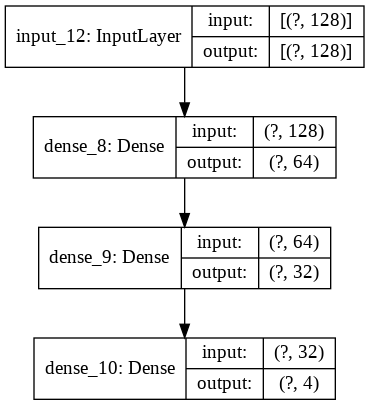

In [ ]:
inputs = Input(shape=layer_sizes)
# x = Embedding(input_dim= len(graph.nodes()), output_dim=64)(inputs)
x = Dense(64, activation="relu")(inputs)
# x = Flatten()(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(4, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs, name="graph_model")
plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, restore_best_weights=True
)

history = model.fit(X_train, 
                    Y_train,
                    batch_size = 128,
                    epochs = 50,
                    validation_data = (X_validation, Y_validation),
                    # callbacks=[es], 
                    verbose = 2)

Epoch 1/50
11/11 - 0s - loss: 1.3964 - accuracy: 0.2737 - val_loss: 1.3869 - val_accuracy: 0.2716
Epoch 2/50
11/11 - 0s - loss: 1.3791 - accuracy: 0.2685 - val_loss: 1.3866 - val_accuracy: 0.2855
Epoch 3/50
11/11 - 0s - loss: 1.3742 - accuracy: 0.2470 - val_loss: 1.3885 - val_accuracy: 0.2578
Epoch 4/50
11/11 - 0s - loss: 1.3719 - accuracy: 0.2693 - val_loss: 1.3841 - val_accuracy: 0.2907
Epoch 5/50
11/11 - 0s - loss: 1.3715 - accuracy: 0.2826 - val_loss: 1.3832 - val_accuracy: 0.2958
Epoch 6/50
11/11 - 0s - loss: 1.3727 - accuracy: 0.2656 - val_loss: 1.3865 - val_accuracy: 0.2457
Epoch 7/50
11/11 - 0s - loss: 1.3734 - accuracy: 0.2849 - val_loss: 1.3835 - val_accuracy: 0.2872
Epoch 8/50
11/11 - 0s - loss: 1.3712 - accuracy: 0.2745 - val_loss: 1.3891 - val_accuracy: 0.2958
Epoch 9/50
11/11 - 0s - loss: 1.3724 - accuracy: 0.2878 - val_loss: 1.3831 - val_accuracy: 0.2457
Epoch 10/50
11/11 - 0s - loss: 1.3720 - accuracy: 0.2774 - val_loss: 1.3842 - val_accuracy: 0.2924
Epoch 11/50
11/11 -

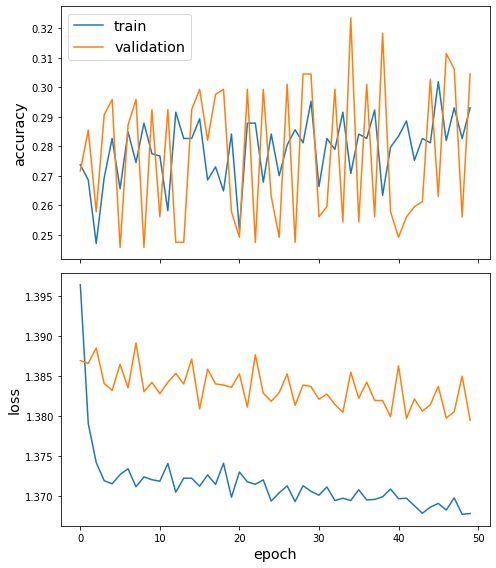

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_metrics = model.evaluate(X_validation, Y_validation)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

19/19 [==============================] - 0s 1ms/step - loss: 1.8704 - accuracy: 0.2612

Test Set Metrics:
	loss: 1.8704
	accuracy: 0.2612
